In [8]:
%matplotlib inline


import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import datacube
from datacube.storage import masking

In [9]:
dc = datacube.Datacube()

In [127]:
lat = (-4.88, -4.76)
lon = (34.72,34.84)

lat = (-4.76, -4.68)
lon = (34.82, 34.90)


In [128]:
query = {
    'lat': lat,
    'lon': lon,
    'time': ('2017-04-01','2017-08-01'),
    'output_crs': 'EPSG:32636',
    'resolution': (-30, 30)
    }

In [129]:
dry_data = dc.load(product='ls8_usgs_sr_scene', group_by='solar_day', measurements=['pixel_qa'], **query)
mask = masking.make_mask(dry_data.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow', nodata=False)
clear_frac = mask.groupby('time').mean().values
time = dry_data.isel(time = (clear_frac == clear_frac.max())).time.values[0]

/usr/local/lib/python3.6/dist-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [130]:
query['time'] = (str(time.astype('M8[D]')-np.timedelta64(0,'D')), str(time.astype('M8[D]')+np.timedelta64(0,'D')))
clear = dc.load(product='ls8_usgs_sr_scene', group_by='solar_day', measurements=['blue','green','red','nir','swir1','swir2'],
                **query)

In [131]:
wofs = dc.load(product='ls_usgs_wofs_scene', group_by='solar_day', **query)

In [132]:
water_mask = masking.make_mask(wofs.water, wet=True)

In [133]:
fc = dc.load(product='ls_usgs_fc_scene', group_by='solar_day', **query)
fc = fc.where(~water_mask)

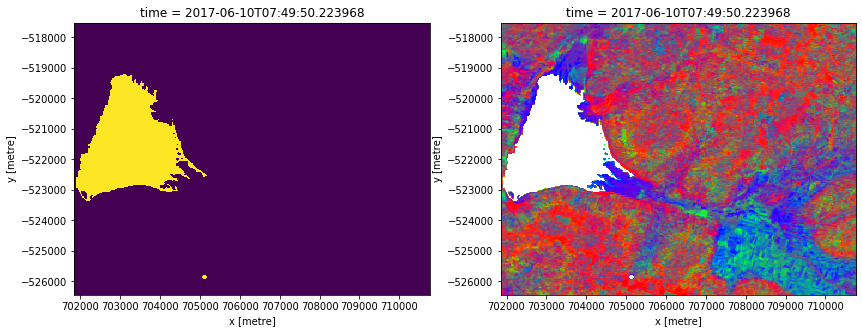

In [134]:
f, axes = plt.subplots(1,2, figsize=(14,5))
wofs.water.squeeze().plot.imshow(robust=True, ax = axes[0], add_colorbar=False);
fc[['BS','PV','NPV']].squeeze().to_array().plot.imshow(robust=True, ax = axes[1]);

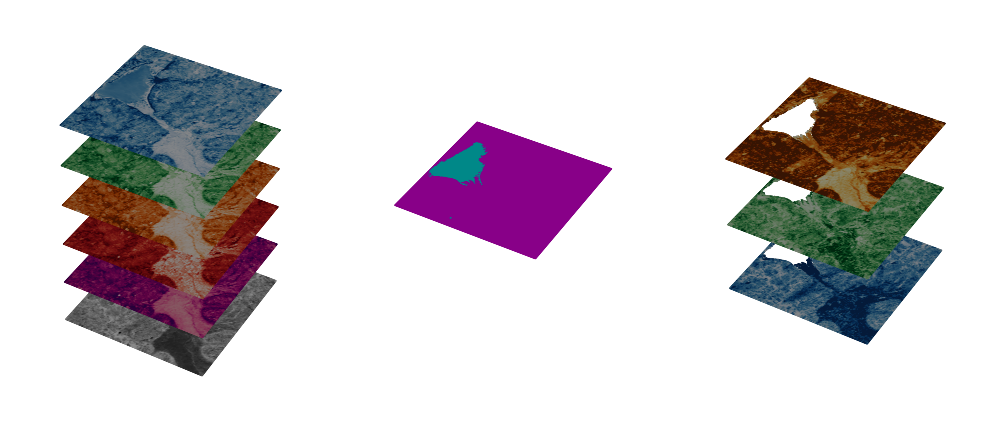

In [162]:
X, Y = np.meshgrid(clear.x.values, clear.y.values);

# Create flat surface.
Z = np.zeros_like(X)

data = clear.squeeze()
water = wofs.squeeze().water
fc = fc.squeeze()

cm_dict={'blue': cm.Blues, 'green':cm.Greens, 'red': cm.Oranges,
        'nir':cm.Reds, 'swir1': cm.RdPu, 'swir2':cm.gray}

cm_fc={'BS': cm.YlOrBr, 'PV': cm.Greens, 'NPV': cm.Blues}

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(131,projection='3d')
ax._axis3don = False
for iband, band in enumerate(list(data.data_vars)):
    vmin = np.nanpercentile(data[band].values,1)
    vmax = np.nanpercentile(data[band].values,99)
    cvalues = (data[band].values-vmin)/(vmax-vmin)
    #print(band, vmin, vmax)
    ax.plot_surface(X, Y, Z-iband*0.1, rstride=1, cstride=1, facecolors = cm_dict[band](cvalues));
ax.set_zlim((-iband*0.1,0.))

ax = fig.add_subplot(132,projection='3d')
ax._axis3don = False
ax.plot_surface(X, Y, Z-0.1*(iband-1)/2, rstride=1, cstride=1, facecolors = cm.cool(1.-water.values));
ax.set_zlim((-iband*0.1,0.))

ax = fig.add_subplot(133,projection='3d')
ax._axis3don = False
for iband, band in enumerate(['BS','PV','NPV']):
    #vmin = np.nanpercentile(fc[band].values,1)
    #vmax = np.nanpercentile(fc[band].values,99)
    vmin, vmax = 0, 50
    cvalues = (fc[band].values-vmin)/(vmax-vmin)
    cvalues = np.ma.masked_array(cvalues, mask=fc[band].isnull().values)
    #print(band, vmin, vmax)
    ax.plot_surface(X, Y, Z-iband*0.1, rstride=1, cstride=1, facecolors = cm_fc[band](cvalues));
ax.set_zlim((-iband*0.1-0.05,0.05))

fig.tight_layout()


fig.savefig('spectral_classification_2.png')

In [189]:
query['time'] = (str(time.astype('M8[D]')-np.timedelta64(100,'D')), str(time.astype('M8[D]')+np.timedelta64(100,'D')))
wofs_series = dc.load(product='ls_usgs_wofs_scene', group_by='solar_day', **query)
mask = masking.make_mask(wofs_series.water, cloud=False, cloud_shadow=False, nodata=False)
clear_frac = mask.groupby('time').mean().values
good = clear_frac>0.95

/usr/local/lib/python3.6/dist-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [190]:
good.sum()

11

In [191]:
water = masking.make_mask(wofs_series.water.isel(time=good), water_observed=True).where(mask.isel(time=good))

In [192]:
summary = water.mean(dim='time')

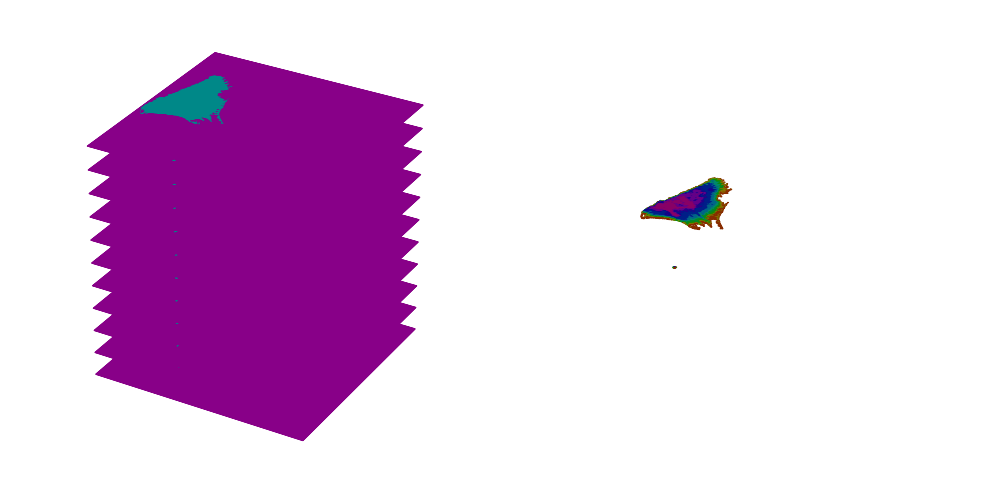

In [204]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121,projection='3d')
ax._axis3don = False
for itime in range(len(water.time)):
    cvalues = 1.-water.isel(time=itime).values
    ax.plot_surface(X, Y, Z-0.1*itime, rstride=1, cstride=1, facecolors = cm.cool(cvalues));
ax.set_zlim((-itime*0.1,0.))

ax = fig.add_subplot(122,projection='3d')
ax._axis3don = False
vmin = np.nanpercentile(summary.values,1)
vmax = np.nanpercentile(summary.values,99)
cvalues = (summary.values-vmin)/(vmax-vmin)
cvalues = np.ma.masked_array(cvalues, mask=cvalues==0)
ax.plot_surface(X, Y, Z-0.1*(itime-1)/2, rstride=1, cstride=1, facecolors = cm.gist_rainbow(cvalues));
ax.set_zlim((-itime*0.1,0.))

fig.tight_layout()
fig.savefig('classification_summary.png')

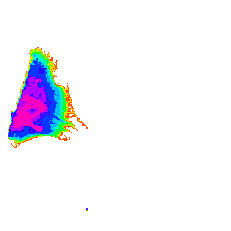

In [205]:
vmin = np.percentile(summary.values,1)
vmax = np.percentile(summary.values,99)
cvalues = (summary.values-vmin)/(vmax-vmin)
cvalues = np.ma.masked_array(cvalues, mask=cvalues==0)
#summary.plot.imshow(cmap=cm.gist_rainbow, add_colorbar=False)
plt.imshow(cvalues, cmap=cm.gist_rainbow, vmin=0,vmax=1)
plt.axis('off')
plt.savefig('summary.png')